In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
from datetime import datetime


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = 999

In [2]:
from itertools import combinations
from scipy.stats import chi2_contingency, f_oneway, ks_2samp
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import plot_confusion_matrix

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import BatchNormalization
from sklearn.metrics import roc_curve

---

# 1. EDA

In [4]:
df = pd.read_csv("./train.csv")

In [5]:
df.head()
df.shape

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,166.500000,11355.000000,34463,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,18.442971,1330.366048,39262,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,68.927835,5999.896907,3622,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,2.000000,96.166667,19562,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,127.404293,2833.847943,7554,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


(5500, 23)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Choice               5500 non-null   int64  
 1   A_follower_count     5500 non-null   int64  
 2   A_following_count    5500 non-null   int64  
 3   A_listed_count       5500 non-null   int64  
 4   A_mentions_received  5500 non-null   float64
 5   A_retweets_received  5500 non-null   float64
 6   A_mentions_sent      5500 non-null   float64
 7   A_retweets_sent      5500 non-null   float64
 8   A_posts              5500 non-null   float64
 9   A_network_feature_1  5500 non-null   int64  
 10  A_network_feature_2  5500 non-null   float64
 11  A_network_feature_3  5500 non-null   float64
 12  B_follower_count     5500 non-null   int64  
 13  B_following_count    5500 non-null   int64  
 14  B_listed_count       5500 non-null   int64  
 15  B_mentions_received  5500 non-null   f

The dataset is quite clean, no null in the data

In [7]:
df.describe()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
count,5500.000000,5.500000e+03,5.500000e+03,5500.000000,5.500000e+03,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5.500000e+03,5500.000000,5500.000000,5.500000e+03,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000
mean,0.509455,6.498840e+05,1.265895e+04,5952.453273,2.666032e+03,1032.371839,6.011873,1.109924,9.090730,5267.768000,84.805209,3747.219758,6.854869e+05,12738.259818,5903.148364,2.554598e+03,997.149954,6.099658,1.106236,9.505821,5254.933636,85.024196,3745.175480
std,0.499956,2.028787e+06,4.900867e+04,17339.141191,2.916543e+04,10954.953223,9.519797,1.910104,18.311060,28946.777345,104.073204,5757.339852,2.160612e+06,50054.520874,16298.462018,2.508873e+04,9342.006880,9.729557,1.939914,19.424680,26778.820125,106.689384,5518.399590
min,0.000000,1.600000e+01,0.000000e+00,0.000000,1.005034e-01,0.100503,0.100503,0.100503,0.100503,0.000000,0.000000,0.000000,2.000000e+01,0.000000,0.000000,1.005034e-01,0.100503,0.100503,0.100503,0.100503,0.000000,0.000000,0.000000
25%,0.000000,2.663750e+03,3.220000e+02,85.000000,3.453649e+00,0.716816,0.359534,0.100503,0.632440,12.000000,14.991870,1180.805341,2.498250e+03,322.000000,75.000000,3.260473e+00,0.714556,0.356943,0.100503,0.822584,11.000000,15.176568,1206.500000
50%,1.000000,4.558900e+04,7.780000e+02,932.000000,4.876542e+01,14.029113,2.299666,0.341936,3.555194,195.000000,54.925234,2206.420734,4.402700e+04,773.000000,890.000000,4.876542e+01,14.029113,2.251398,0.341936,3.342999,190.000000,54.925234,2206.420734
75%,1.000000,3.927380e+05,2.838000e+03,6734.000000,3.498196e+02,118.704407,7.198330,1.320681,10.691878,1323.000000,109.695652,4390.379310,3.701142e+05,2838.000000,6734.000000,3.743699e+02,107.081021,6.866840,1.320681,10.600502,1323.000000,112.191489,4349.908608
max,1.000000,3.654319e+07,1.165830e+06,549144.000000,1.145219e+06,435825.874241,76.809514,16.290540,193.072418,920838.000000,1121.000000,144651.461538,3.654319e+07,664324.000000,549144.000000,1.145219e+06,435825.874241,76.809514,16.290540,193.072418,920838.000000,1861.583333,75526.083333


---

Since we are trying to compare two users, it is intuitive to derive differenctial features between them.

In [8]:
feature11 = ['follower_count', 'following_count', 'listed_count', 'mentions_received', 
             'retweets_received', 'mentions_sent','retweets_sent', 'posts', 'network_feature_1',
               'network_feature_2', 'network_feature_3']

In [9]:
for i in feature11:
    
    #differnce (A-B)
    df[i+'_diff'] = df['A_'+i] - df['B_'+i]
    
    #ratio (A/B)
    df[i+'_ratio'] = df['A_'+i] - df['B_'+i]
    
    #flag that A > B, 1 if A > B, 0 if A = B, -1 if A < B
    df[i+'_f'] = np.where(df[i+'_diff'] > 0, 1,
                         np.where(df[i+'_diff'] == 0, 0, -1))

---

### choice

In [10]:
df.Choice.value_counts()

1    2802
0    2698
Name: Choice, dtype: int64

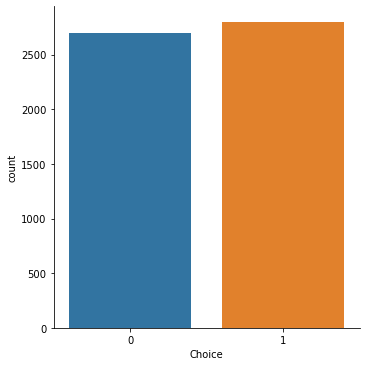

In [11]:
_ = sns.catplot(data = df, x = 'Choice', kind = 'count')

Note: The dataset is quite balance. No need to undersampling or oversampling.

### follower_count

the variable can varies from order of ten to millions, better use log scale for visualization.

In [12]:
feature = 'follower_count'

In [13]:
df[df[f'A_{feature}'] == 0].shape[0]
df[df[f'B_{feature}'] == 0].shape[0]

0

0

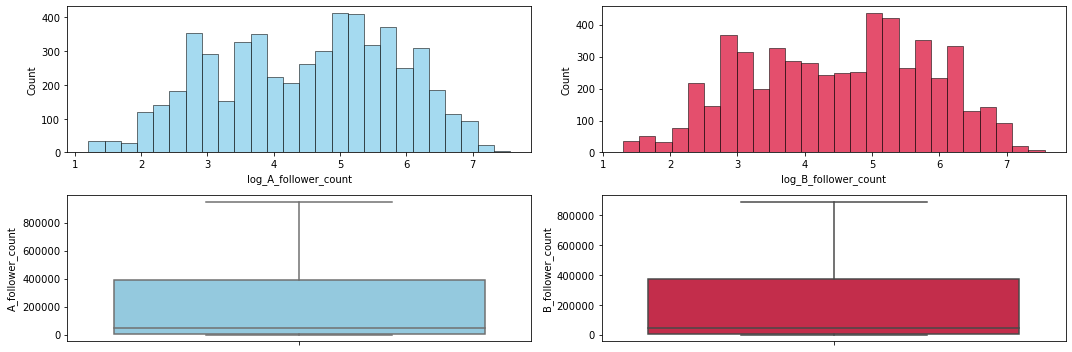

In [14]:
df[f'log_A_{feature}'] = np.log10(df[f'A_{feature}'])
df[f'log_B_{feature}'] = np.log10(df[f'B_{feature}'])

fig, axes = plt.subplots(2, 2)
_ = sns.histplot(data = df, x=f"log_A_{feature}", ax = axes[0,0], color = 'skyblue')
_ = sns.histplot(data = df, x=f"log_B_{feature}", ax = axes[0,1], color = 'crimson')
_ = sns.boxplot(data = df, y=f"A_{feature}", ax = axes[1,0], showfliers = False, color = 'skyblue')
_ = sns.boxplot(data = df, y=f"B_{feature}", ax = axes[1,1], showfliers = False, color = 'crimson')

_ = fig.set_figwidth(15)
_ = fig.set_figheight(5)
    
_ = fig.tight_layout()

 1    2753
-1    2746
 0       1
Name: follower_count_f, dtype: int64

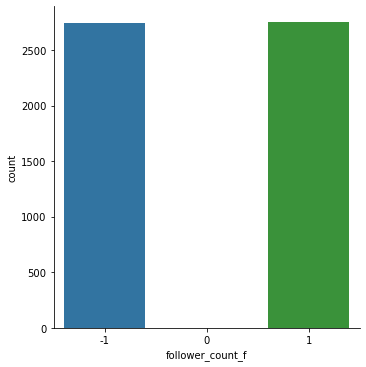

In [15]:
df[f'{feature}_f'].value_counts()
_ = sns.catplot(data = df, x = f'{feature}_f', kind = 'count')

Note: We found that, roughly, A_follower_count > B_follower_count on half of the samples and on the other half B_follower_count > A_follower_count. This is perfect because our model will learn from both scenario equally.

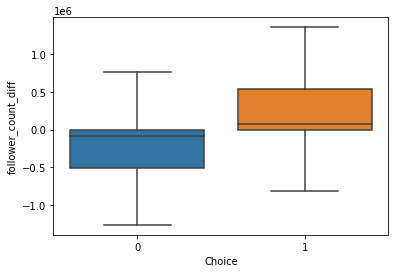

In [16]:
_ = sns.boxplot(data = df, x = 'Choice' ,y = f'{feature}_diff', showfliers = False)

Note: We also found that the variable 'follower_count' alone has a predictive power. 75%(approximately) of the class 1 have positive follower_count_diff. Meaning that if a person A have higher follower than a person B, there is a high chance that A is more influential than B. This is also true for the other way around.

So let check this in a more concrete way.

In [17]:
df.groupby(f'{feature}_f').Choice.mean()

follower_count_f
-1    0.256737
 0    0.000000
 1    0.761714
Name: Choice, dtype: float64

This mean that even if we use this variable alone we will get at least 75% accuracy.

In [18]:
predict_from_follower_count = np.where(df.follower_count_f >= 0, 1, 0)

In [19]:
accuracy = accuracy_score(df.Choice, predict_from_follower_count)
print('accuracy score: ', accuracy)

accuracy score:  0.7523636363636363


Let keep this as a benchmark.

### following_count

In [20]:
feature = 'following_count'

In [21]:
df[df[f'A_{feature}'] == 0].shape[0]
df[df[f'B_{feature}'] == 0].shape[0]

35

32

/Users/630212/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/630212/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


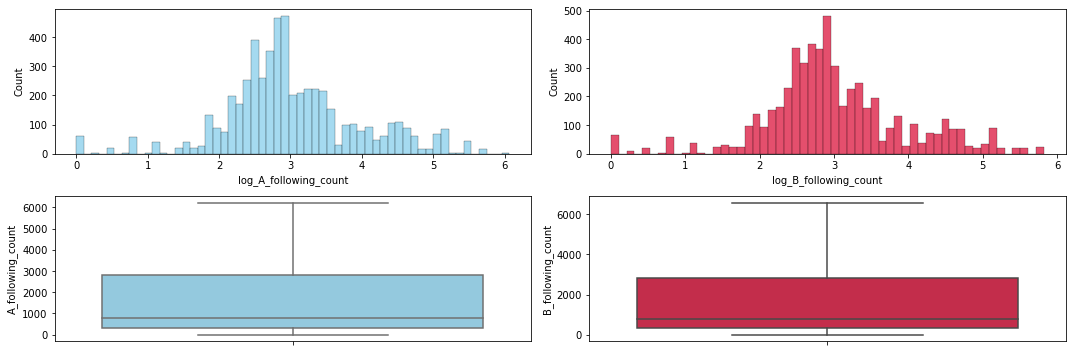

In [22]:
df[f'log_A_{feature}'] = np.where(df[f'A_{feature}'] != 0, np.log10(df[f'A_{feature}']), 0)
df[f'log_B_{feature}'] = np.where(df[f'B_{feature}'] != 0, np.log10(df[f'B_{feature}']), 0)

fig, axes = plt.subplots(2, 2)
_ = sns.histplot(data = df, x=f"log_A_{feature}", ax = axes[0,0], color = 'skyblue')
_ = sns.histplot(data = df, x=f"log_B_{feature}", ax = axes[0,1], color = 'crimson')
_ = sns.boxplot(data = df, y=f"A_{feature}", ax = axes[1,0], showfliers = False, color = 'skyblue')
_ = sns.boxplot(data = df, y=f"B_{feature}", ax = axes[1,1], showfliers = False, color = 'crimson')

_ = fig.set_figwidth(15)
_ = fig.set_figheight(5)
    
_ = fig.tight_layout()

 1    2784
-1    2713
 0       3
Name: following_count_f, dtype: int64

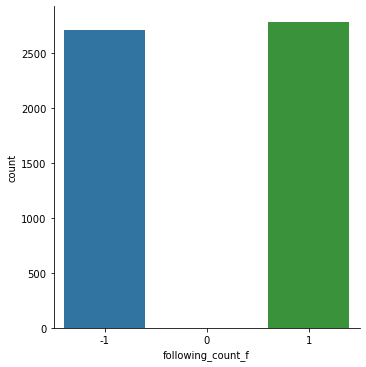

In [23]:
df[f'{feature}_f'].value_counts()
_ = sns.catplot(data = df, x = f'{feature}_f', kind = 'count')

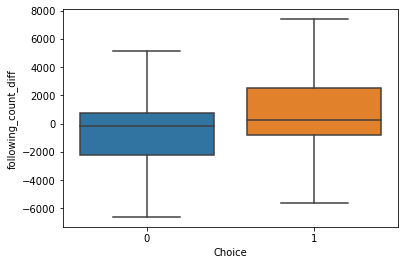

In [24]:
_ = sns.boxplot(data = df, x = 'Choice' ,y = f'{feature}_diff', showfliers = False)

In [25]:
df.groupby(f'{feature}_f').Choice.mean()

following_count_f
-1    0.435311
 0    0.666667
 1    0.581537
Name: Choice, dtype: float64

Note: following_count alone is not as much predictive as follower_count. The data also split equally for following_count_f.

### others feature

In [26]:
other_features = ['listed_count', 'mentions_received', 'retweets_received', 'mentions_sent', 'retweets_sent',
 'posts', 'network_feature_1', 'network_feature_2', 'network_feature_3']

listed_count


60

46

/Users/630212/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/630212/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


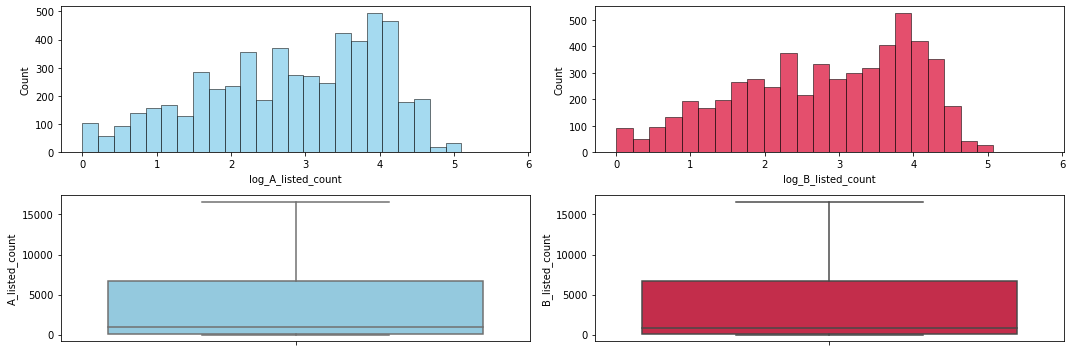

 1    2790
-1    2705
 0       5
Name: listed_count_f, dtype: int64

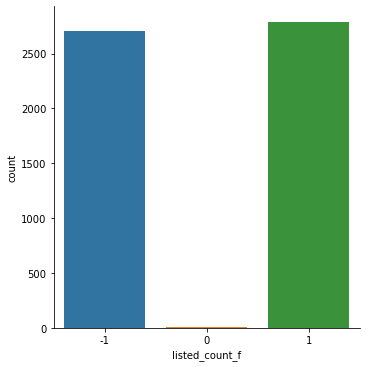

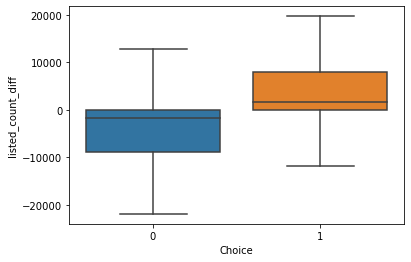

listed_count_f
-1    0.245841
 0    0.400000
 1    0.765233
Name: Choice, dtype: float64

----------------------------------------------------------------------------------------------------
mentions_received


0

0

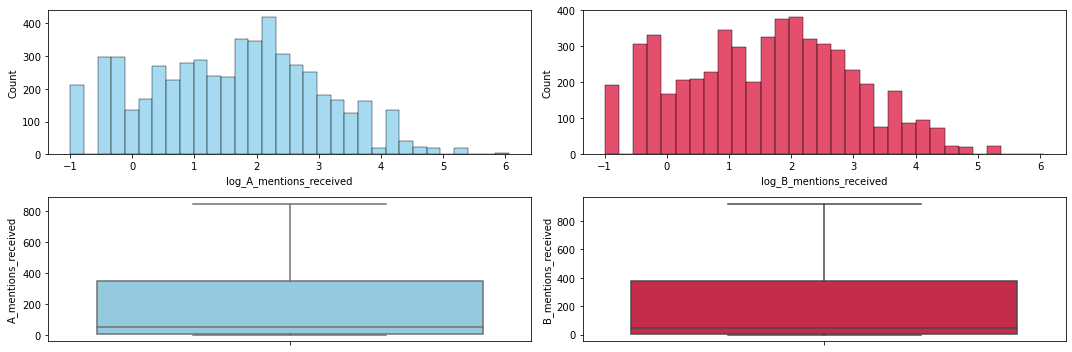

-1    2753
 1    2743
 0       4
Name: mentions_received_f, dtype: int64

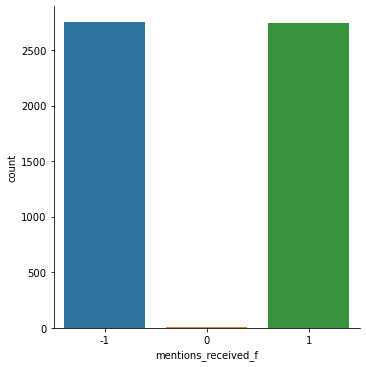

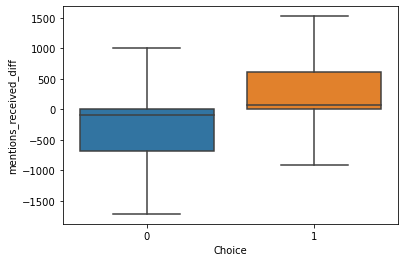

mentions_received_f
-1    0.260443
 0    0.500000
 1    0.759388
Name: Choice, dtype: float64

----------------------------------------------------------------------------------------------------
retweets_received


0

0

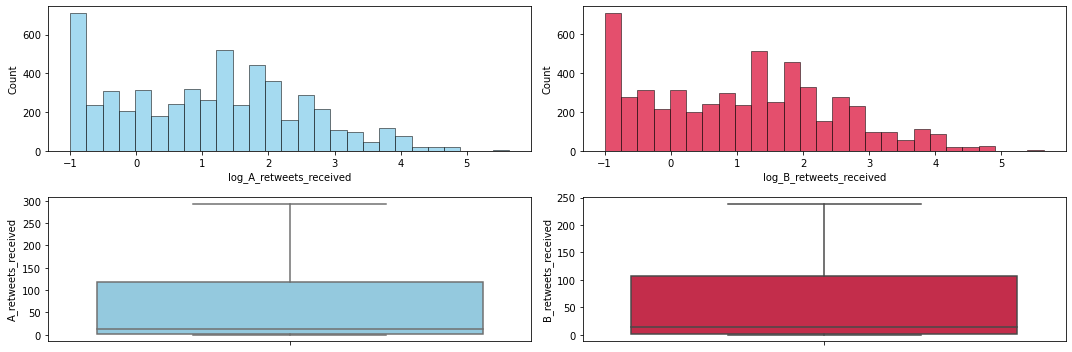

 1    2723
-1    2682
 0      95
Name: retweets_received_f, dtype: int64

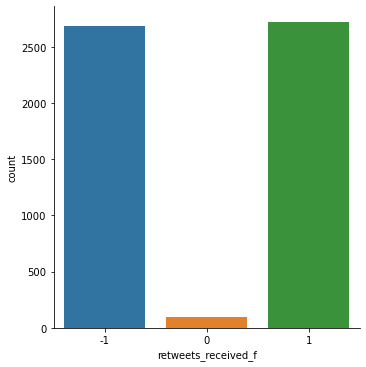

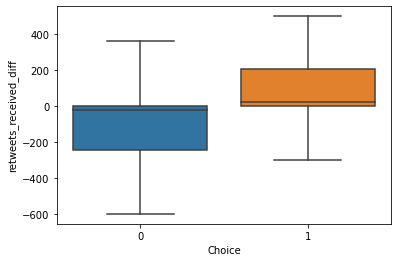

retweets_received_f
-1    0.257644
 0    0.600000
 1    0.754315
Name: Choice, dtype: float64

----------------------------------------------------------------------------------------------------
mentions_sent


0

0

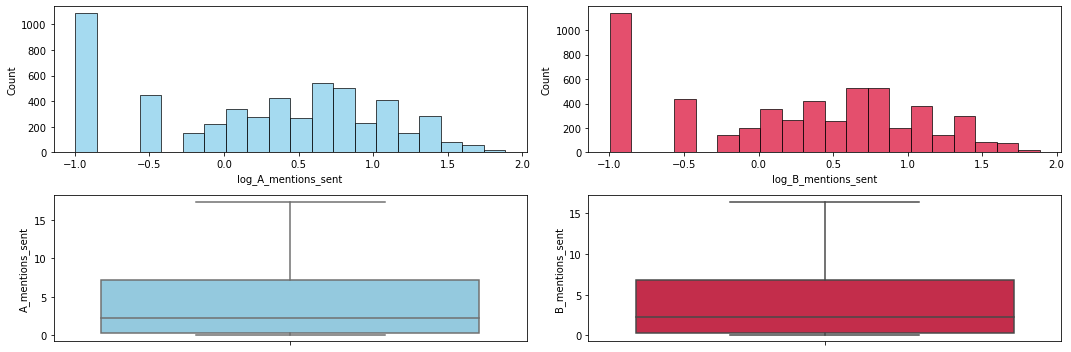

 1    2651
-1    2623
 0     226
Name: mentions_sent_f, dtype: int64

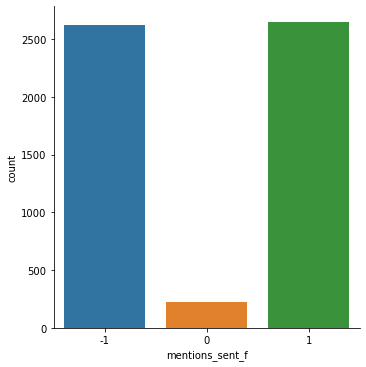

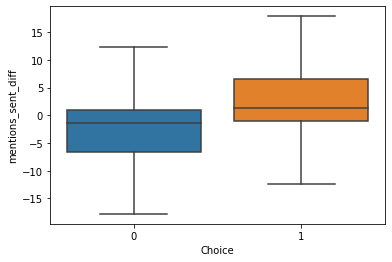

mentions_sent_f
-1    0.361037
 0    0.491150
 1    0.657865
Name: Choice, dtype: float64

----------------------------------------------------------------------------------------------------
retweets_sent


0

0

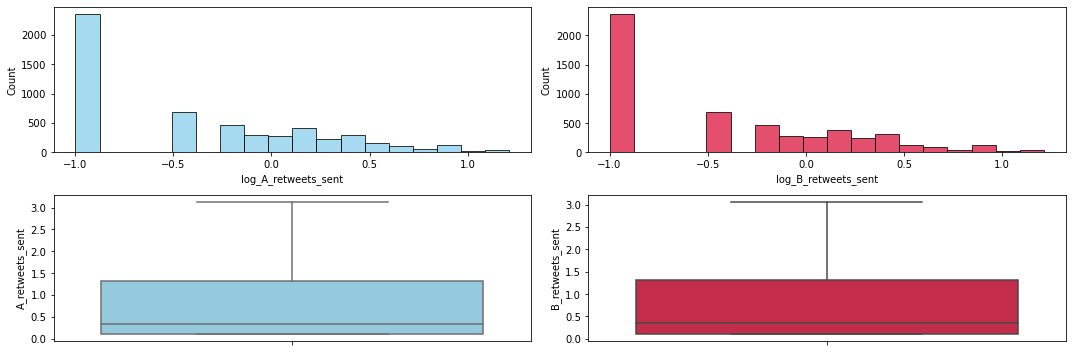

-1    2255
 1    2224
 0    1021
Name: retweets_sent_f, dtype: int64

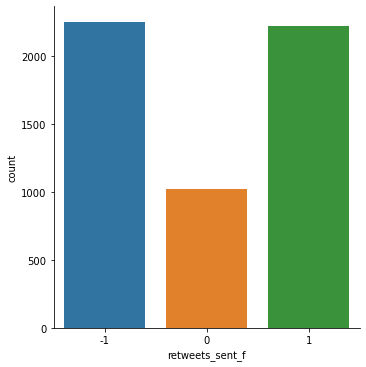

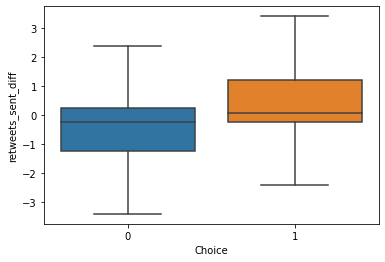

retweets_sent_f
-1    0.368071
 0    0.529873
 1    0.643435
Name: Choice, dtype: float64

----------------------------------------------------------------------------------------------------
posts


0

0

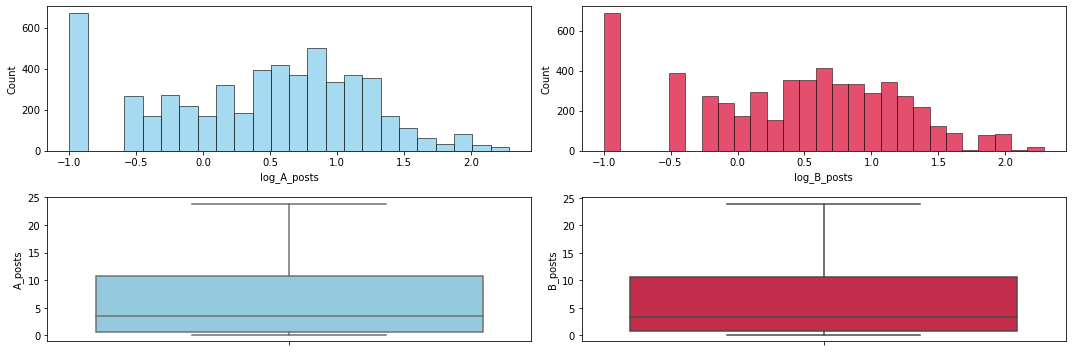

-1    2711
 1    2704
 0      85
Name: posts_f, dtype: int64

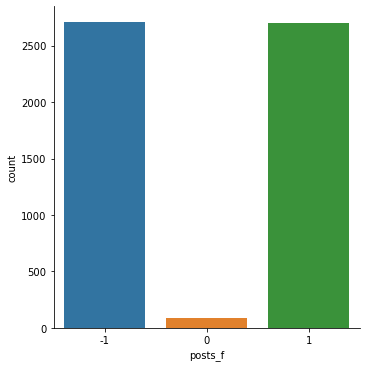

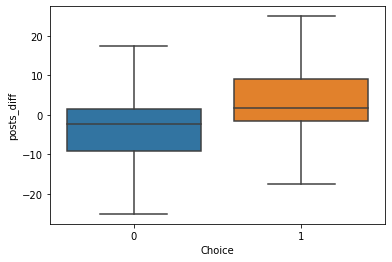

posts_f
-1    0.363703
 0    0.470588
 1    0.656805
Name: Choice, dtype: float64

----------------------------------------------------------------------------------------------------
network_feature_1


212

194

/Users/630212/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/630212/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


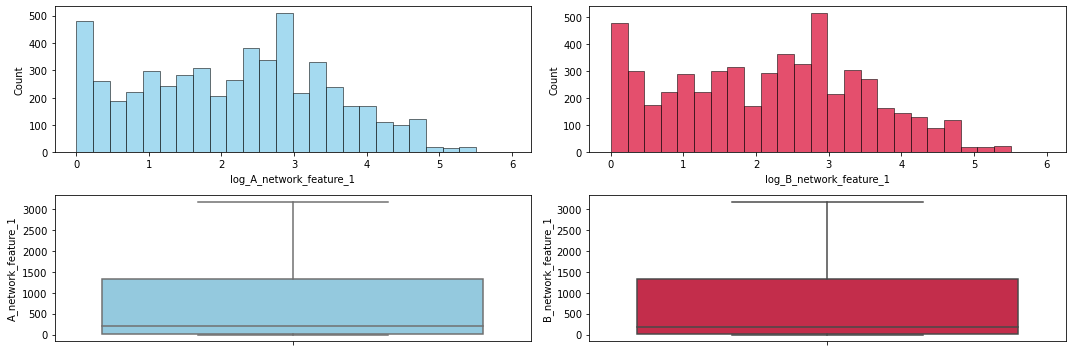

 1    2738
-1    2719
 0      43
Name: network_feature_1_f, dtype: int64

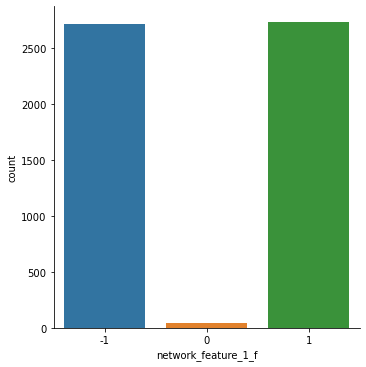

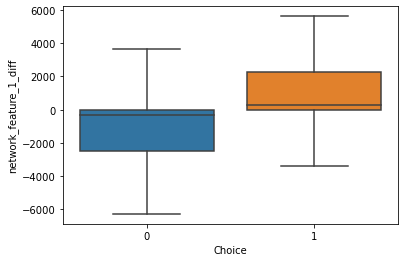

network_feature_1_f
-1    0.251931
 0    0.581395
 1    0.764061
Name: Choice, dtype: float64

----------------------------------------------------------------------------------------------------
network_feature_2


346

341

/Users/630212/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/630212/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


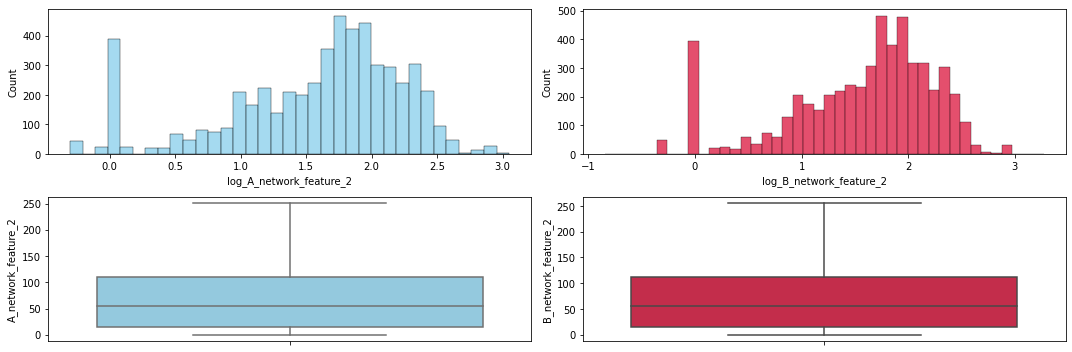

 1    2744
-1    2739
 0      17
Name: network_feature_2_f, dtype: int64

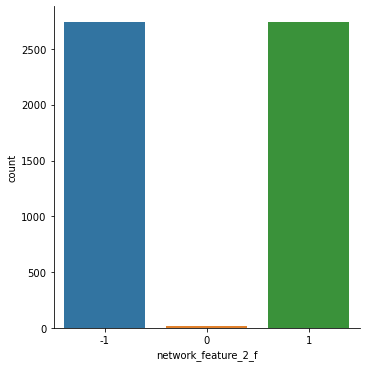

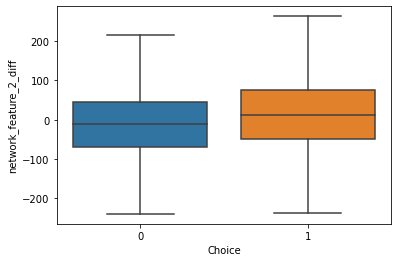

network_feature_2_f
-1    0.441037
 0    0.588235
 1    0.577259
Name: Choice, dtype: float64

----------------------------------------------------------------------------------------------------
network_feature_3


260

247

/Users/630212/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/630212/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


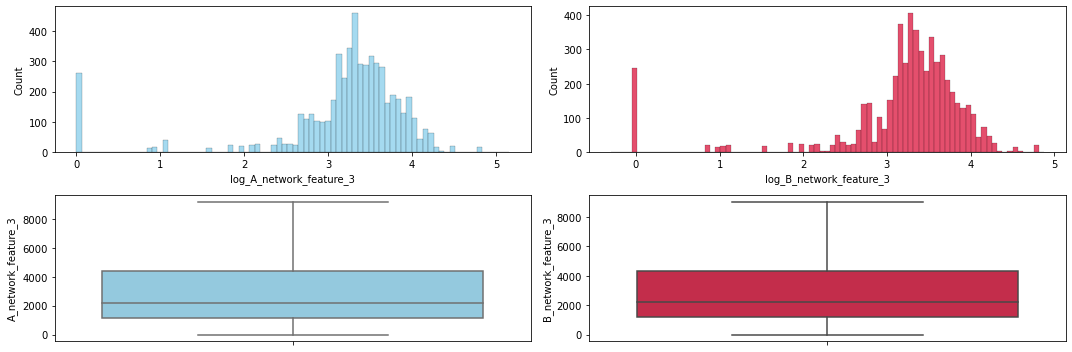

-1    2803
 1    2690
 0       7
Name: network_feature_3_f, dtype: int64

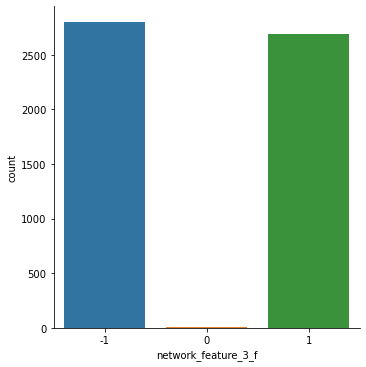

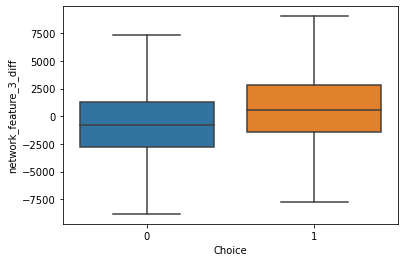

network_feature_3_f
-1    0.414913
 0    0.571429
 1    0.607807
Name: Choice, dtype: float64

----------------------------------------------------------------------------------------------------


In [27]:
for feature in other_features:
    
    print(feature)

    df[df[f'A_{feature}'] == 0].shape[0]
    df[df[f'B_{feature}'] == 0].shape[0]

    df[f'log_A_{feature}'] = np.where(df[f'A_{feature}'] != 0, np.log10(df[f'A_{feature}']), 0)
    df[f'log_B_{feature}'] = np.where(df[f'B_{feature}'] != 0, np.log10(df[f'B_{feature}']), 0)

    fig, axes = plt.subplots(2, 2)
    _ = sns.histplot(data = df, x=f"log_A_{feature}", ax = axes[0,0], color = 'skyblue')
    _ = sns.histplot(data = df, x=f"log_B_{feature}", ax = axes[0,1], color = 'crimson')
    _ = sns.boxplot(data = df, y=f"A_{feature}", ax = axes[1,0], showfliers = False, color = 'skyblue')
    _ = sns.boxplot(data = df, y=f"B_{feature}", ax = axes[1,1], showfliers = False, color = 'crimson')

    _ = fig.set_figwidth(15)
    _ = fig.set_figheight(5)
    _ = fig.tight_layout()
    _ = plt.show()

    df[f'{feature}_f'].value_counts()
    _ = sns.catplot(data = df, x = f'{feature}_f', kind = 'count')
    _ = plt.show()
    
    _ = sns.boxplot(data = df, x = 'Choice' ,y = f'{feature}_diff', showfliers = False)
    _ = plt.show()
    df.groupby(f'{feature}_f').Choice.mean()
    
    print('----------------------------------------------------------------------------------------------------')

In [28]:
#delete log columns
for x in df.columns:
    if 'log' in x:
        del df[x]

# 2. Generate more sample

The problem is comparing A against B, we can get more date just from swaping the order and flip the target class, meaning that we compare B against A instead.

In [29]:
df = pd.read_csv("./train.csv")

In [30]:
df_A = df[['A_'+x for x in feature11]]
rename_dict_A = {'A_'+x:'B_'+x for x in feature11}
df_A = df_A.rename(columns = rename_dict_A)

In [31]:
df_B = df[['B_'+x for x in feature11]]
rename_dict_B = {'B_'+x:'A_'+x for x in feature11}
df_B = df_B.rename(columns = rename_dict_B)

In [32]:
df_swap = pd.concat([df_B, df_A], axis = 1)

In [33]:
df_swap['Choice'] = df['Choice'].map({0:1, 1:0})

In [34]:
df_swap = df_swap[['Choice']+[x for x in df_swap.columns if x != 'Choice']]

In [35]:
df = pd.concat([df,df_swap], axis = 0)

In [36]:
df = df.reset_index(drop = True)

One has to be careful that the original date set already have rows from swaping A, B. So, drop duplicate to make sure that we got unique data point.

In [37]:
df = df.drop_duplicates()

In [38]:
df.shape

(10408, 23)

some rows are indeed dropped.

In [39]:
# derive variable again
for i in feature11:
    
    #differnce (A-B)
    df[i+'_diff'] = df['A_'+i] - df['B_'+i]

Next, we will try to build a model from two set of features, namely, the original features and derived features. The set with better performance will be picked.

In [40]:
original_feature = [x for x in df.columns if any(y in x for y in ['A_', 'B_'])]

diff_feature = [x for x in df.columns if 'diff' in x]

# 3. Split data into train, validation and test set

In [41]:
X = df[[x for x in df.columns if x != 'Choice']]
y = df['Choice']

In [42]:
X1, X_test, y1, y_test = train_test_split(X, y, random_state = 35, stratify = y, test_size = 0.1)

X_train, X_val, y_train, y_val = train_test_split(X1, y1, random_state = 45, stratify = y1, test_size = 0.1)

#will use this for gridsearch
split_index = [-1 if x in X_train.index else 0 for x in X1.index]

pds = PredefinedSplit(test_fold = split_index)

In [43]:
X_train.shape
X_val.shape
X_test.shape

y_train.shape
y_val.shape
y_test.shape

(8430, 33)

(937, 33)

(1041, 33)

(8430,)

(937,)

(1041,)

### check distribution of train, val, test set

Next, we check that the all train, validation and test set have the same distribution

In [44]:
dist_train = X_train.copy()
dist_train['dataset'] = 'train'

dist_val = X_val.copy()
dist_val['dataset'] = 'val'

dist_test = X_test.copy()
dist_test['dataset'] = 'test'

dist_all = pd.concat([dist_train, dist_val, dist_test])

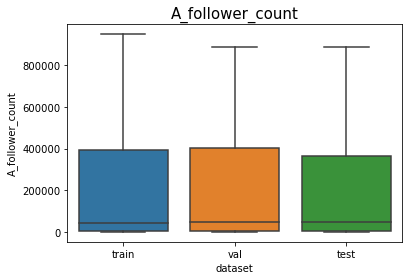

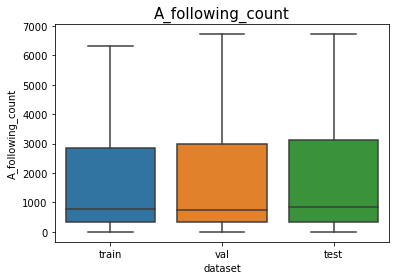

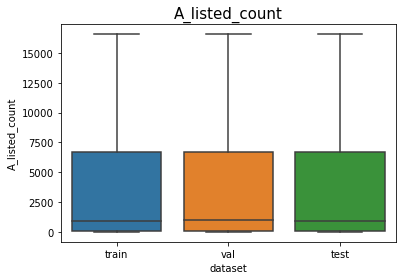

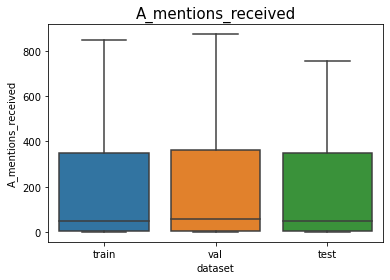

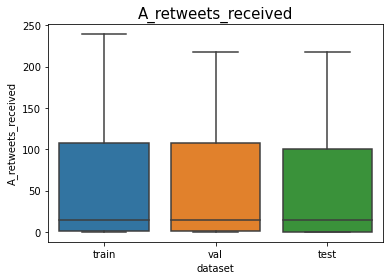

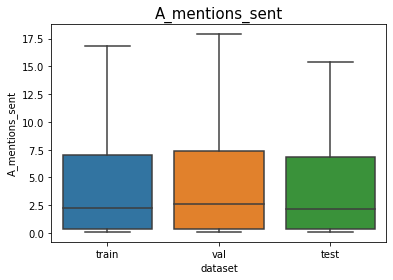

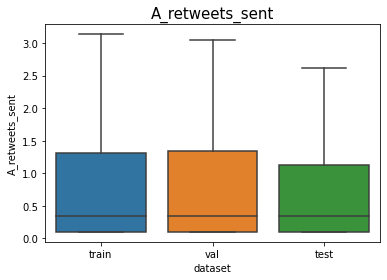

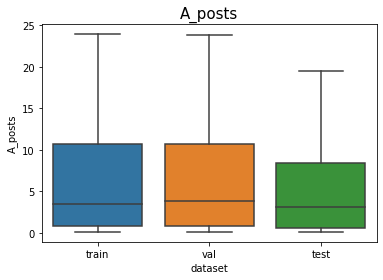

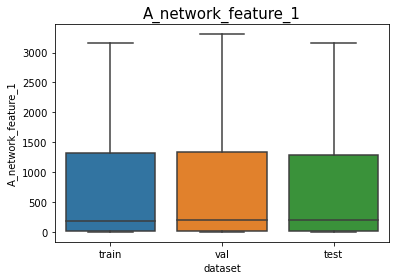

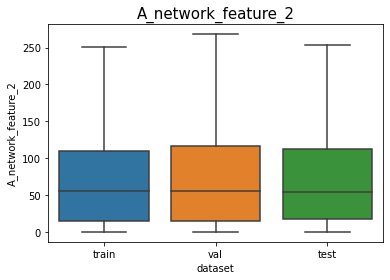

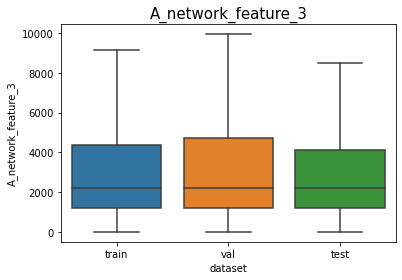

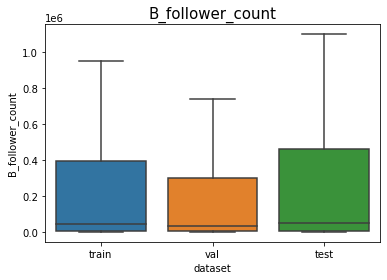

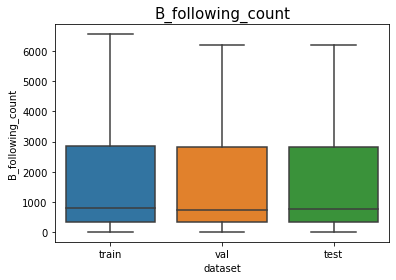

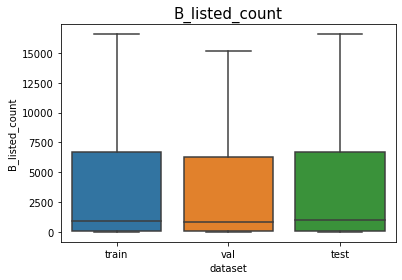

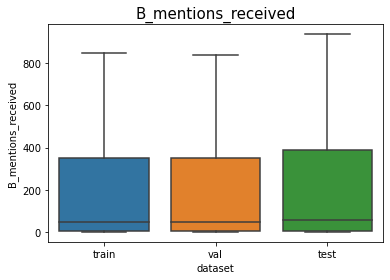

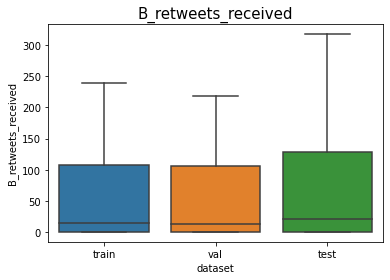

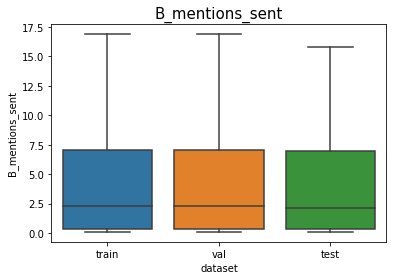

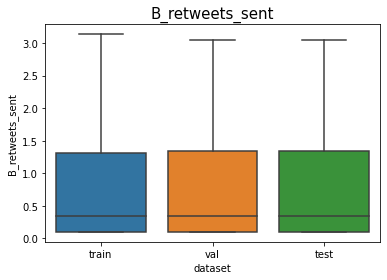

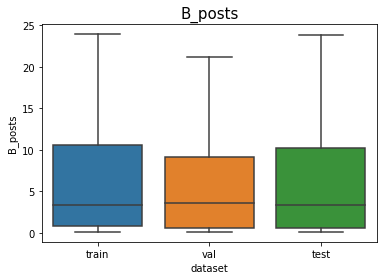

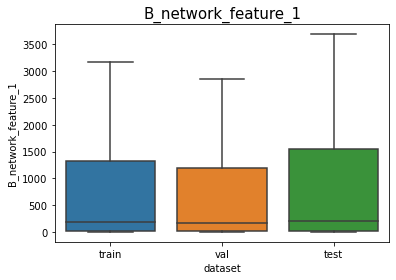

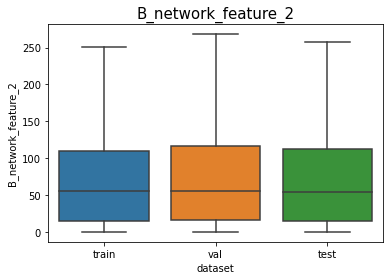

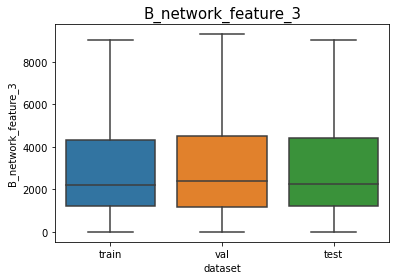

In [45]:
for i in original_feature:
    _ = sns.boxplot(data = dist_all, x = 'dataset', y = i, showfliers = False)
    _ = plt.title(i, fontsize=15)
    _ = plt.show()

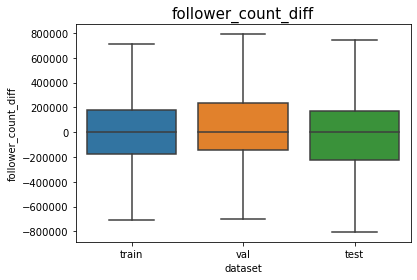

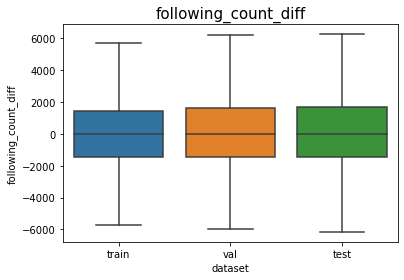

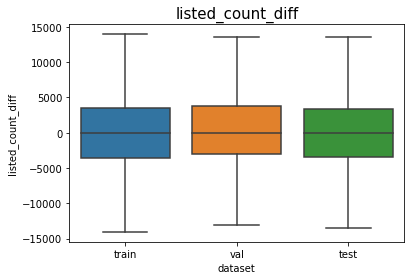

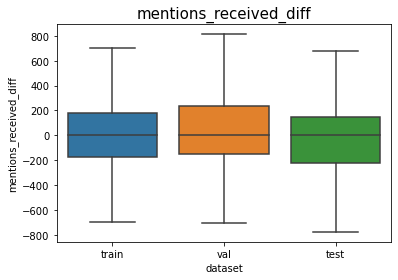

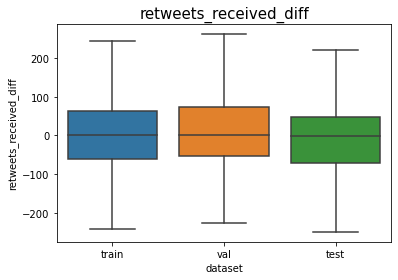

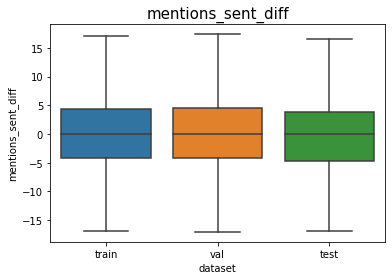

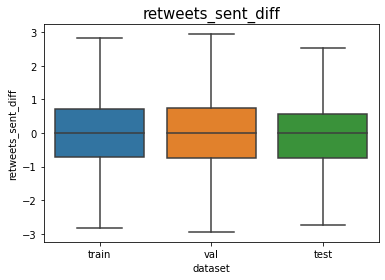

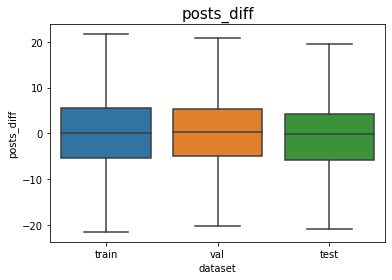

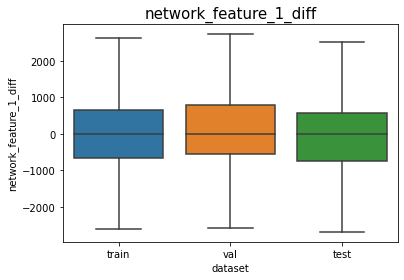

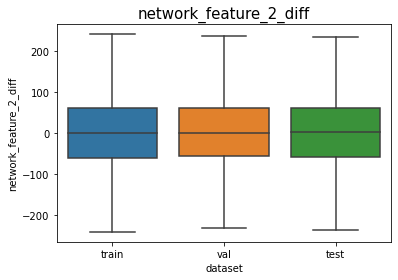

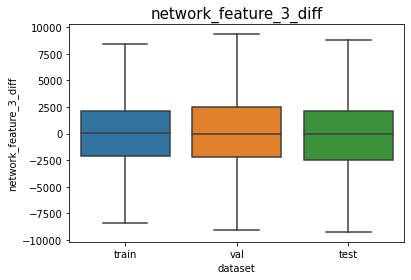

In [46]:
for i in diff_feature:
    _ = sns.boxplot(data = dist_all, x = 'dataset', y = i, showfliers = False)
    _ = plt.title(i, fontsize=15)
    _ = plt.show()

Visually, all distribution are quite similar. But let be more concrete by using statistical test.

#### mean test with anova (significance level = 0.05)

In [47]:
original_feature_fail_anova = []
for i in original_feature:
    d_data = {grp:dist_all[dist_all.dataset == grp][i] for grp in ['train', 'val', 'test']}
    F, p = f_oneway(d_data['train'], d_data['val'], d_data['test'])
    if p < 0.05:
        original_feature_fail_anova.append({'feature':i, 'p value':p})

In [48]:
original_feature_fail_anova

[]

In [49]:
diff_feature_fail_anova = []
for i in diff_feature:
    d_data = {grp:dist_all[dist_all.dataset == grp][i] for grp in ['train', 'val', 'test']}
    F, p = f_oneway(d_data['train'], d_data['val'], d_data['test'])
    if p < 0.05:
        diff_feature_fail_anova.append({'feature':i, 'p value':p})

In [50]:
diff_feature_fail_anova

[]

#### distribution test with KS (significance level = 0.05)

In [51]:
original_feature_fail_ks = []
for i in original_feature:
    d_data = {grp:dist_all[dist_all.dataset == grp][i] for grp in ['train', 'val', 'test']}
    ks_train_val, p_train_val = ks_2samp(d_data['train'], d_data['val'])
    ks_train_test, p_train_test = ks_2samp(d_data['train'], d_data['test'])
    if p_train_val < 0.05:
        original_feature_fail_ks.append({'feature':i, 'dataset': 'train-val','p value':p_train_val})
    if p_train_test < 0.05:
        original_feature_fail_ks.append({'feature':i, 'dataset': 'train-test','p value':p_train_tets})

In [52]:
original_feature_fail_ks

[]

In [53]:
diff_feature_fail_ks = []
for i in diff_feature:
    d_data = {grp:dist_all[dist_all.dataset == grp][i] for grp in ['train', 'val', 'test']}
    ks_train_val, p_train_val = ks_2samp(d_data['train'], d_data['val'])
    ks_train_test, p_train_test = ks_2samp(d_data['train'], d_data['test'])
    if p_train_val < 0.05:
        diff_feature_fail_ks.append({'feature':i, 'dataset': 'train-val','p value':p_train_val})
    if p_train_test < 0.05:
        diff_feature_fail_ks.append({'feature':i, 'dataset': 'train-test','p value':p_train_tets})

In [54]:
diff_feature_fail_ks

[{'feature': 'listed_count_diff',
  'dataset': 'train-val',
  'p value': 0.044862943084512885}]

Not too bad for our split, altough one of the feature fail KS-test. For now we will just proceed with this split and keep that window open for an improvement if necessary.

# 4. Feature Selection

### Remove constant feature

In [55]:
constant_feature = [x for x in X_train.columns if (X_train[x].nunique() == 1)]
constant_feature

[]

In [56]:
X_train.drop(columns = constant_feature, inplace = True)
X_val.drop(columns = constant_feature, inplace = True)
X_test.drop(columns = constant_feature, inplace = True)

/Users/630212/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Remove Quasi-constant feature

remove feature that > 99% of the values are the same

In [57]:
quasi_constant_feature = []
for x in X_train.columns:

    predominant = X_train[x].value_counts(normalize = True).sort_values(ascending=False).values[0]

    if predominant > 0.99:
        quasi_constant_feature.append(x)
        
quasi_constant_feature

[]

In [58]:
X_train.drop(columns = quasi_constant_feature, inplace = True)
X_val.drop(columns = quasi_constant_feature, inplace = True)
X_test.drop(columns = quasi_constant_feature, inplace = True)

### Remove duplicated feature

In [59]:
factors_paired = list(combinations(X_train.columns, 2))

duplicated_pair = []

for f in factors_paired:
    if X_train[f[0]].equals(X_train[f[1]]):
        duplicated_pair.append()
        
duplicated_pair

[]

### Remove corelated feature

#### original feature

<AxesSubplot:>

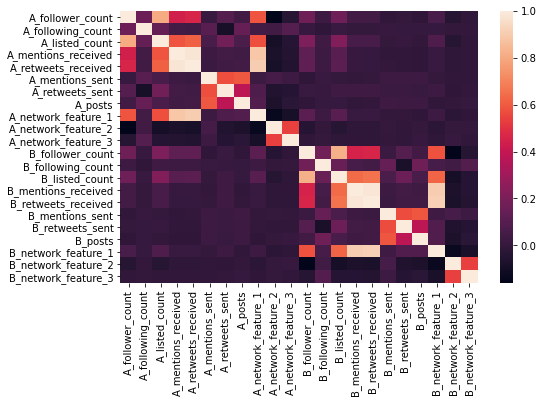

In [60]:
# correlation matrix plot
corrmat = X_train[original_feature].corr()
fig, ax = plt.subplots()
fig.set_size_inches(8,5)
sns.heatmap(corrmat)

In [61]:
# correlation table
corrmat = X_train[original_feature].corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,B_retweets_received,B_mentions_received,0.985913
1,B_mentions_received,B_retweets_received,0.985913
2,A_retweets_received,A_mentions_received,0.981533
3,A_mentions_received,A_retweets_received,0.981533
4,B_network_feature_1,B_retweets_received,0.915191


In [62]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
# print('out of {} total features'.format(X_train.shape[1]))

found 4 correlated groups


In [63]:
#group 1
correlated_groups[0]

,feature1,feature2,corr
0,B_retweets_received,B_mentions_received,0.985913
5,B_retweets_received,B_network_feature_1,0.915191


In [64]:
#group 2
correlated_groups[1]

,feature1,feature2,corr
2,A_retweets_received,A_mentions_received,0.981533
9,A_retweets_received,A_network_feature_1,0.906696


Note: from group 1,2 we can see that retweets_received, mentions_received, network_feature_1 are correlated. We will keep retweets_received.

In [65]:
#group 3
correlated_groups[2]

,feature1,feature2,corr
12,B_listed_count,B_follower_count,0.823365


In [66]:
#group 4
correlated_groups[3]

,feature1,feature2,corr
14,A_listed_count,A_follower_count,0.806815


Note: from group 3,4 we can see that follower_count, listed_count are correlated. We will keep follower_count.

In [67]:
original_feature = [x for x in original_feature if not any(y in x for y in ['mentions_received', 'network_feature_1', 'listed_count'])]

#### diff feature

<AxesSubplot:>

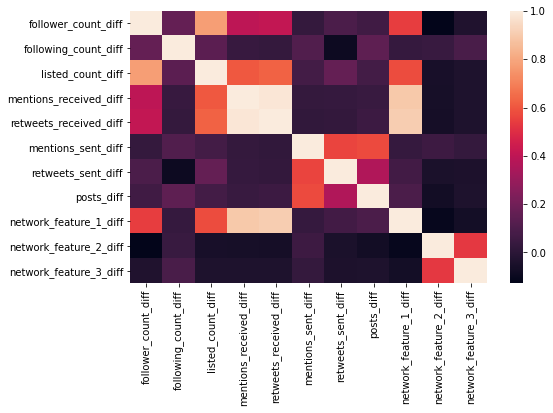

In [68]:
# correlation matrix plot
corrmat = X_train[diff_feature].corr()
fig, ax = plt.subplots()
fig.set_size_inches(8,5)
sns.heatmap(corrmat)

In [69]:
# correlation table
corrmat = X_train[diff_feature].corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,retweets_received_diff,mentions_received_diff,0.983821
1,mentions_received_diff,retweets_received_diff,0.983821
2,network_feature_1_diff,retweets_received_diff,0.909213
3,retweets_received_diff,network_feature_1_diff,0.909213
4,network_feature_1_diff,mentions_received_diff,0.898760


In [70]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
# print('out of {} total features'.format(X_train.shape[1]))

found 1 correlated groups


In [71]:
correlated_groups[0]

,feature1,feature2,corr
0,retweets_received_diff,mentions_received_diff,0.983821
3,retweets_received_diff,network_feature_1_diff,0.909213


Note: drop mentions_received_diff, network_feature_1_diff

In [72]:
diff_feature = [x for x in diff_feature if x not in ['mentions_received_diff', 'network_feature_1_diff']]

# 5. Model with original feature

In [81]:
param_grid = {
    'n_estimators':[500,700,1000],
    'max_depth':[2,3,4],
    'num_leaves':[4,8,16],
    'learning_rate':[0.01,0.05,0.1],
    'feature_fraction':[0.9, 1],
    'bagging_fraction':[0.9, 1],
}

In [82]:
estimator = LGBMClassifier(boosting_type = 'gbdt', objective = 'binary', metric = ['auc'])

In [83]:
clf = GridSearchCV(estimator = estimator,
                   cv=pds,
                   param_grid=param_grid,
                   scoring = 'roc_auc')

In [84]:
time_start = datetime.now()
clf.fit(X1[original_feature],y1)
print('time collapes: ', datetime.now() - time_start)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=LGBMClassifier(metric=['auc'], objective='binary'),
             param_grid={'bagging_fraction': [0.9, 1],
                         'feature_fraction': [0.9, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [500, 700, 1000],
                         'num_leaves': [4, 8, 16]},
             scoring='roc_auc')

time collapes:  0:01:00.471645


In [85]:
clf.best_score_

0.8905290397827712

In [86]:
clf.best_params_

{'bagging_fraction': 0.9,
 'feature_fraction': 1,
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 1000,
 'num_leaves': 4}

In [87]:
model1 = LGBMClassifier(
    boosting_type = 'gbdt',
    objective = 'binary',
    metric = ['auc'],
    n_estimators = 1000,
    max_depth = 2,
    num_leaves = 4,
    learning_rate = 0.05,
    bagging_fraction =  0.9,
    feature_fraction =  1
)

In [88]:
model1.fit(X_train[original_feature], y_train, verbose = 100,
          eval_metric = 'auc',
          eval_set = [(X_train[original_feature], y_train),(X_val[original_feature], y_val)]
        )

[100]	valid_0's auc: 0.864358	valid_1's auc: 0.873424
[200]	valid_0's auc: 0.874027	valid_1's auc: 0.88193
[300]	valid_0's auc: 0.879567	valid_1's auc: 0.884709
[400]	valid_0's auc: 0.88415	valid_1's auc: 0.886677
[500]	valid_0's auc: 0.888058	valid_1's auc: 0.887515
[600]	valid_0's auc: 0.89159	valid_1's auc: 0.888461
[700]	valid_0's auc: 0.894543	valid_1's auc: 0.889208
[800]	valid_0's auc: 0.897008	valid_1's auc: 0.889814
[900]	valid_0's auc: 0.899492	valid_1's auc: 0.89021
[1000]	valid_0's auc: 0.901763	valid_1's auc: 0.890529


LGBMClassifier(bagging_fraction=0.9, feature_fraction=1, learning_rate=0.05,
               max_depth=2, metric=['auc'], n_estimators=1000, num_leaves=4,
               objective='binary')

In [89]:
roc_auc_score(y_test, model1.predict_proba(X_test[original_feature])[:,1])

0.8543905950095969

<AxesSubplot:>

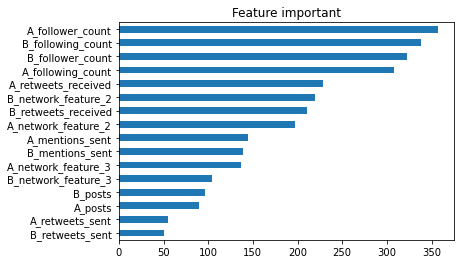

In [139]:
feat_importances = pd.Series(model1.feature_importances_, index=X_train[original_feature].columns)
feat_importances.nlargest(20).sort_values().plot(kind='barh')
_ = plt.title("Feature important")
_ = plt.show()

# Model with diff feature

In [90]:
param_grid = {
    'n_estimators':[500,700,1000],
    'max_depth':[2,3,4],
    'num_leaves':[4,8,16],
    'learning_rate':[0.01,0.05,0.1],
#     'reg_alpha':[0, 0.1],  
#     'reg_lambda':[0, 0.1],
    'feature_fraction':[0.9, 1],
    'bagging_fraction':[0.9, 1],
}

In [91]:
estimator = LGBMClassifier(boosting_type = 'gbdt', objective = 'binary', metric = ['auc'])

In [92]:
clf = GridSearchCV(estimator = estimator,
                   cv=pds,
                   param_grid=param_grid,
                   scoring = 'roc_auc')

In [93]:
time_start = datetime.now()
clf.fit(X1[diff_feature],y1)
print('time collapes: ', datetime.now() - time_start)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=LGBMClassifier(metric=['auc'], objective='binary'),
             param_grid={'bagging_fraction': [0.9, 1],
                         'feature_fraction': [0.9, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [500, 700, 1000],
                         'num_leaves': [4, 8, 16]},
             scoring='roc_auc')

time collapes:  0:02:27.166815


In [94]:
clf.best_score_

0.864619211634137

In [95]:
clf.best_params_

{'bagging_fraction': 0.9,
 'feature_fraction': 1,
 'learning_rate': 0.01,
 'max_depth': 4,
 'n_estimators': 1000,
 'num_leaves': 8}

In [96]:
model2 = LGBMClassifier(
    boosting_type = 'gbdt',
    objective = 'binary',
    metric = ['auc'],
    n_estimators = 1000,
    max_depth = 4,
    num_leaves = 8,
    learning_rate = 0.01,
    bagging_fraction =  0.9,
    feature_fraction =  1
)

In [97]:
model2.fit(X_train[diff_feature], y_train, verbose = 100,
          eval_metric = 'auc',
          eval_set = [(X_train[diff_feature], y_train),(X_val[diff_feature], y_val)]
        )

[100]	valid_0's auc: 0.842655	valid_1's auc: 0.846081
[200]	valid_0's auc: 0.84829	valid_1's auc: 0.851698
[300]	valid_0's auc: 0.852921	valid_1's auc: 0.855366
[400]	valid_0's auc: 0.856734	valid_1's auc: 0.858241
[500]	valid_0's auc: 0.859899	valid_1's auc: 0.860179
[600]	valid_0's auc: 0.862565	valid_1's auc: 0.862086
[700]	valid_0's auc: 0.865007	valid_1's auc: 0.862888
[800]	valid_0's auc: 0.867386	valid_1's auc: 0.863621
[900]	valid_0's auc: 0.869675	valid_1's auc: 0.864232
[1000]	valid_0's auc: 0.871778	valid_1's auc: 0.864619


LGBMClassifier(bagging_fraction=0.9, feature_fraction=1, learning_rate=0.01,
               max_depth=4, metric=['auc'], n_estimators=1000, num_leaves=8,
               objective='binary')

In [100]:
roc_auc_score(y_test, model2.predict_proba(X_test[diff_feature])[:,1])

0.8200132880555145

---

The model with original set of features perform better than the derived feature. So, we wil use it as a fianl model.

# 6. Evaluation

In [132]:
print('train auc : ', roc_auc_score(y_train, model1.predict_proba(X_train[original_feature])[:,1]))
print('validation auc: ', roc_auc_score(y_val, model1.predict_proba(X_val[original_feature])[:,1]))
print('test auc: ', roc_auc_score(y_test, model1.predict_proba(X_test[original_feature])[:,1]))

train auc :  0.9017632051828679
validation auc:  0.8905290397827712
test auc:  0.8543905950095969


Train set

              precision    recall  f1-score   support

           0      0.811     0.814     0.812      4215
           1      0.813     0.811     0.812      4215

    accuracy                          0.812      8430
   macro avg      0.812     0.812     0.812      8430
weighted avg      0.812     0.812     0.812      8430



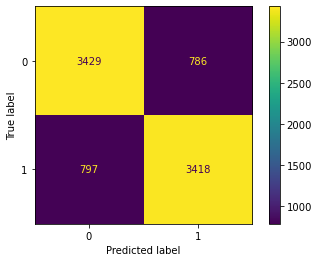

In [133]:
print('Train set\n')
print(classification_report(y_train, model1.predict(X_train[original_feature]), digits=3))
_ = plot_confusion_matrix(model1, X_train[original_feature], y_train)

Validation set

              precision    recall  f1-score   support

           0      0.806     0.789     0.797       469
           1      0.793     0.810     0.801       468

    accuracy                          0.799       937
   macro avg      0.799     0.799     0.799       937
weighted avg      0.800     0.799     0.799       937



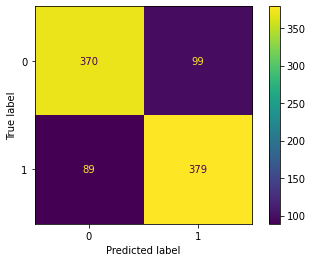

In [134]:
print('Validation set\n')
print(classification_report(y_val, model1.predict(X_val[original_feature]), digits=3))
_ = plot_confusion_matrix(model1, X_val[original_feature], y_val)

Test set

              precision    recall  f1-score   support

           0      0.761     0.771     0.766       520
           1      0.768     0.758     0.763       521

    accuracy                          0.765      1041
   macro avg      0.765     0.765     0.765      1041
weighted avg      0.765     0.765     0.765      1041



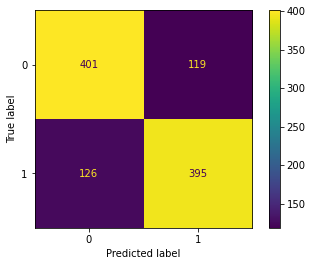

In [135]:
print('Test set\n')
print(classification_report(y_test, model1.predict(X_test[original_feature]), digits=3))
_ = plot_confusion_matrix(model1, X_test[original_feature], y_test)

# Kaggle submit

In [115]:
test = pd.read_csv("./test.csv")

In [116]:
test.head()

,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,A_network_feature_2,A_network_feature_3,B_follower_count,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,614689,400,5729,199.618296,67.812469,9.366192,0.359534,4.094488,669,39.193741,2565.612519,1404323,563,20057,967.720642,579.431128,4.473798,0.805680,6.241806,4027,57.643839,3201.293706
1,739581,10723,1279,102.026750,96.771319,1.537322,1.054358,3.467754,432,11.191686,966.193995,756715,12949,1311,38.260522,10.697567,12.845793,1.584284,12.106662,144,209.717241,21496.565517
2,3638,3341,85,2.793577,1.402703,2.594089,0.598150,3.802143,11,9.416667,489.083333,488750,320,3673,1207.190077,599.721600,0.842022,0.593199,7.044735,3918,7.859818,637.983300
3,613,1259,31,1.326041,0.356943,6.249678,2.323064,7.488116,4,5.000000,275.000000,13456,3599,1072,10.300222,3.828561,1.624092,0.100503,1.614287,43,113.840909,2537.772727
4,1352348,331,15647,19129.848662,14552.733991,2.065418,0.580955,16.281502,52580,3.092448,597.563636,1481379,147521,15043,9902.070379,5012.055876,10.438460,0.100503,193.072418,28564,10.964144,1035.955493


In [119]:
prediction = model1.predict_proba(test[original_feature])[:,1]

In [120]:
prediction = pd.DataFrame({'Choice':prediction})

In [121]:
prediction = prediction.reset_index()

In [122]:
prediction.rename(columns = {'index':'Id'}, inplace = True)

In [123]:
prediction['Id'] = prediction['Id']+1

In [124]:
prediction.head()

,Id,Choice
0,1,0.138775
1,2,0.329394
2,3,0.213765
3,4,0.313294
4,5,0.649343


In [125]:
prediction.to_csv('./lgbm_diff_feature.csv', index = False)